In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip'
df = pd.read_csv(url, encoding='latin-1')
toDrop = ['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'MIGRANTE', 'PAIS_ORIGEN']
df.drop(toDrop, axis=1, inplace=True)

In [3]:
dates = ['FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']

df[dates] = df[dates].transform(pd.to_datetime, errors='coerce')

df['DIAS_PRE_HOSP'] = (df.FECHA_INGRESO - df.FECHA_SINTOMAS).dt.days
df['DIAS_PRE_DEF'] = (df.FECHA_DEF - df.FECHA_INGRESO).dt.days
df['DIAS_TOT'] = df.DIAS_PRE_HOSP + df.DIAS_PRE_DEF

In [4]:
df['SOBREVIVE'] = df.FECHA_DEF.isnull().astype(int)
df.SEXO = df.SEXO - 1
df.TIPO_PACIENTE = df.TIPO_PACIENTE - 1

prev = ['NEUMONIA', 'DIABETES', 'EPOC',
        'ASMA', 'INMUSUPR', 'HIPERTENSION',
        'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
        'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO',
        'RESULTADO', 'INTUBADO', 'NACIONALIDAD',
        'EMBARAZO', 'HABLA_LENGUA_INDIG', 'UCI']

for p in prev:
    df[p] = [0 if row == 2
               else 1 if row == 1
               else np.nan
               for row in df[p]]

In [5]:
new_cases = df[df.RESULTADO == 1].groupby('FECHA_SINTOMAS').size()
new_deaths = df[df.SOBREVIVE == 0].groupby('FECHA_SINTOMAS').size()
nd_cov = (df[(df.SOBREVIVE == 0) & (df.RESULTADO == 1)]
          .groupby('FECHA_SINTOMAS')
          .size())

cum_cases = new_cases.cumsum()
cum_deaths = new_deaths.cumsum()
cum_nd_cov = nd_cov.cumsum()

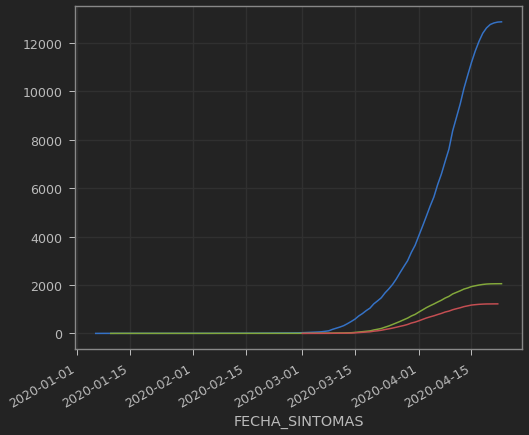

In [6]:
cum_cases.plot()
cum_deaths.plot()
cum_nd_cov.plot()

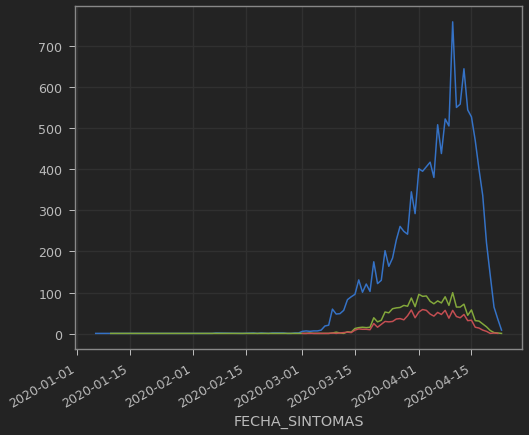

In [7]:
new_cases.plot()
new_deaths.plot()
nd_cov.plot()

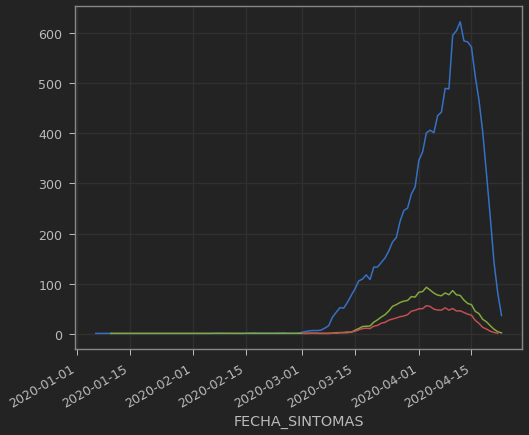

In [16]:
w = '3d'
nc_roll = new_cases.rolling(w)
nd_roll = new_deaths.rolling(w)
ndc_roll = nd_cov.rolling(w)

nc_roll.mean().plot()
nd_roll.mean().plot()
ndc_roll.mean().plot()

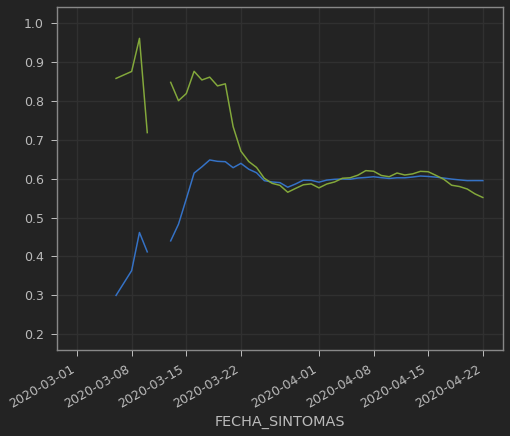

In [9]:
(cum_nd_cov / cum_deaths).plot()
(ndc_roll.mean() / nd_roll.mean()).plot()

In [381]:
df_pos = df[(df.RESULTADO == 1)]
to_drop = ['FECHA_ACTUALIZACION', 'FECHA_INGRESO',
           'FECHA_SINTOMAS', 'FECHA_DEF', 'DIAS_PRE_DEF',
           'DIAS_TOT', 'PAIS_NACIONALIDAD', 'MUNICIPIO_RES',
           'TIPO_PACIENTE', 'INTUBADO', 'UCI',
           'RESULTADO', 'NEUMONIA', 'ENTIDAD_UM', 'ENTIDAD_NAC',
           'ENTIDAD_RES', 'NACIONALIDAD']
dfp = df_pos.drop(to_drop, axis=1)

In [382]:
e_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
         20,21,22,23,24,25,26,27,28,29,30,31,32,36,97,98,99]
e_ab = ['Aguascalientes','Baja California','Baja California Sur','Campeche','Coahuila',
        'Colima','Chiapas','Chihuahua','Ciudad de México','Durango',
        'Guanajuato','Guerrero','Hidalgo','Jalisco','Estado de México',
        'Michoacán','Morelos','Nayarit','Nuevo León','Oaxaca',
        'Puebla','Querétaro','Quintana Roo','San Luis Potosí','Sinaloa',
        'Sonora','Tabasco','Tamaulipas','Tlaxcala','Veracruz',
        'Yucatán','Zacatecas','Estados Unidos Mexicanos','No Aplica','Se Ignora','No Especificado']
mun = {k: v for k, v in zip(e_num, e_ab)}

dfp.rename(columns={'DIAS_PRE_HOSP': 'Días sintomático sin hospitalizar',
                    'OTRA_COM': 'Otro padecimiento',
                    'OTRO_CASO': 'Contacto con contagiado',
                    'SEXO': 'Sexo masculino',
                    'HABLA_LENGUA_INDIG': 'Habla lengua indígena',
                    'DIABETES': 'Diabetes', 'ASMA': 'Asma', 'HIPERTENSION': 'Hipertensión',
                    'INMUSUPR': 'Inmunosupresión', 'CARDIOVASCULAR': 'Enfermedad cardiovascular',
                    'OBESIDAD': 'Obesidad', 'RENAL_CRONICA': 'Enfermedad renal crónica',
                    'TABAQUISMO': 'Tabaquismo', 'EMBARAZO': 'Embarazo'},
           inplace=True)

ents = [
#         'Unidad_Medica',
#         'Entidad_Nacimiento',
#         'Estado'
       ]
# dfp.replace({e: mun for e in ents}, inplace=True)

dfp.EDAD = pd.qcut(dfp.EDAD, 5)

to_onehot = ['EDAD'] + ents
ohs = {toh: pd.get_dummies(dfp[toh]).add_prefix(toh + '_') for toh in to_onehot}
for toh in to_onehot:
    dfp = (dfp.drop(toh, axis=1)
           .join(ohs[toh]))

dfp.fillna(dfp.mode().iloc[0], inplace=True)

## ML Models to Predict Survival

In [383]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV

sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("Reds_r", 10))

clf = LogisticRegressionCV(max_iter=1000)

ages = ['EDAD_(-0.001, 33.0]',
        'EDAD_(33.0, 42.0]',
        'EDAD_(42.0, 50.0]',
        'EDAD_(50.0, 60.0]',
        'EDAD_(60.0, 113.0]']

### Grupo 0-33

In [404]:
df_sub = dfp[dfp[ages[0]] == 1]
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.9869407256258398

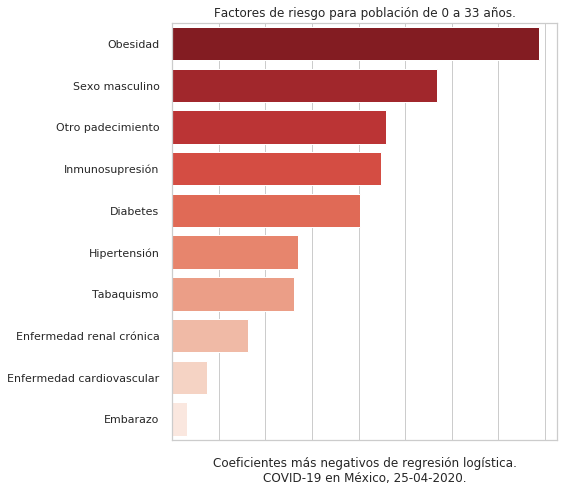

In [410]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(10)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para población de 0 a 33 años.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_0a33.pdf', transparent=True)

### Grupo 34-42

In [411]:
df_sub = dfp[dfp[ages[1]] == 1]
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.9637347787347788

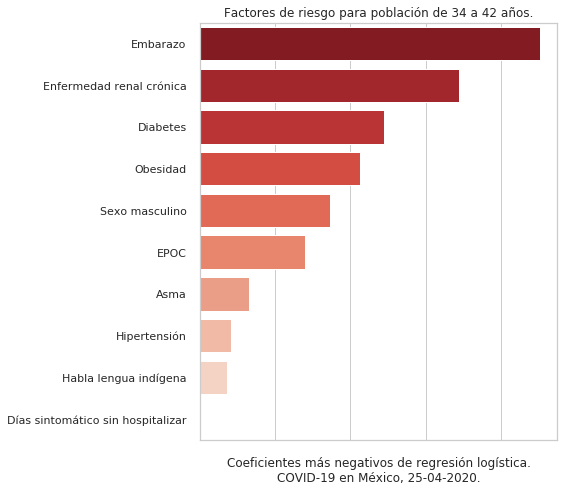

In [412]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(10)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para población de 34 a 42 años.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_34a42.pdf', transparent=True)

### Grupo 43-50

In [413]:
df_sub = dfp[dfp[ages[2]] == 1]
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.9189751004016065

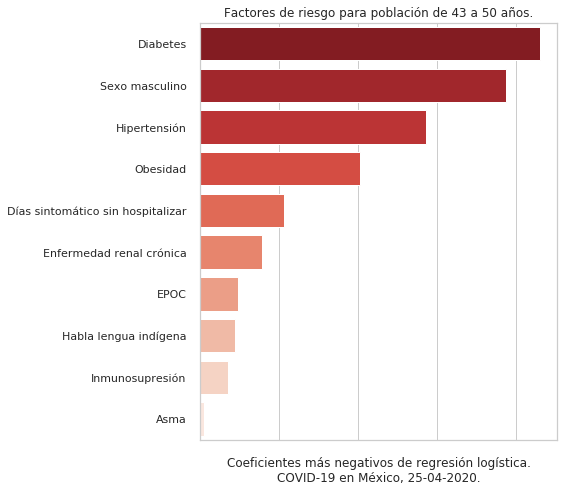

In [414]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(10)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para población de 43 a 50 años.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_43a50.pdf', transparent=True)

### Grupo 51-60

In [415]:
df_sub = dfp[dfp[ages[3]] == 1]
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.8765740311872781

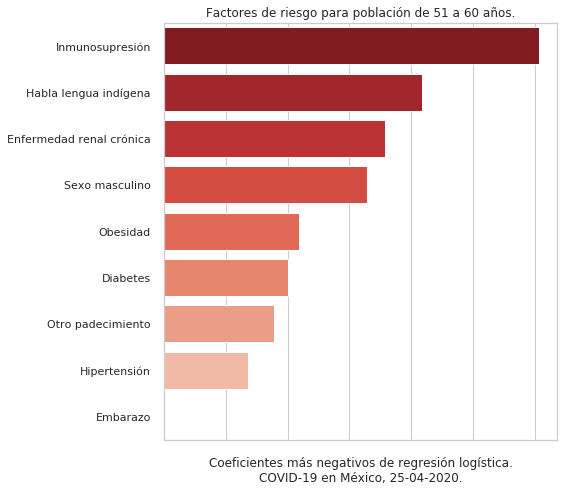

In [417]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(9)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para población de 51 a 60 años.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_51a60.pdf', transparent=True)

### Grupo 61+

In [418]:
df_sub = dfp[dfp[ages[4]] == 1]
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.7639004149377593

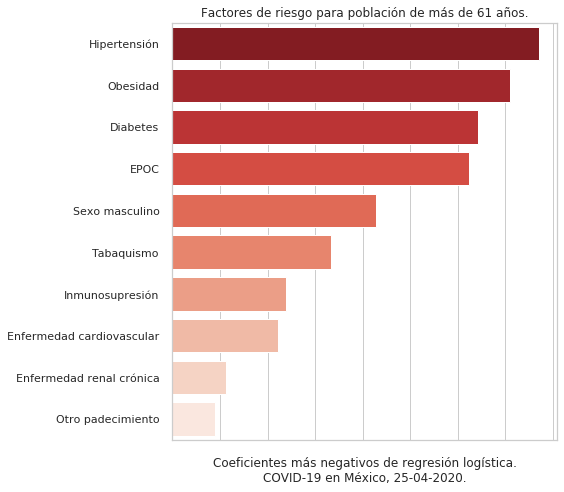

In [419]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(10)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para población de más de 61 años.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_61+.pdf', transparent=True)

## Riesgo General

In [420]:
df_sub = dfp
data = df_sub.drop(ages + ['SOBREVIVE'], axis=1)
target = df_sub.SOBREVIVE
np.mean(cross_val_score(clf, data, target, cv=10))

0.904832184723489

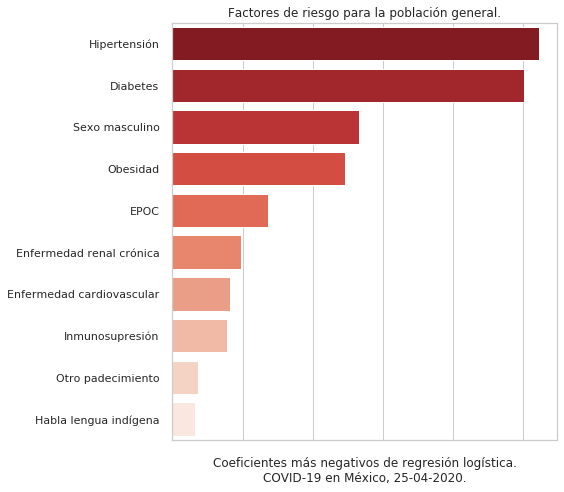

In [421]:
clf = clf.fit(data, target)
coefs = pd.DataFrame({'Variable': data.columns.values,
                      'Riesgo': clf.coef_[0] * -1})
coefs = coefs.sort_values(by='Riesgo', ascending=False).head(10)

sns.barplot(x="Riesgo", y="Variable", data=coefs).set_title('Factores de riesgo para la población general.')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
plt.ylabel('')
plt.xlabel(r'Coeficientes más negativos de regresión logística.'
           '\n'
           r'COVID-19 en México, 25-04-2020.')
plt.tight_layout()
plt.savefig('../Graphics/Riesgo_General.pdf', transparent=True)

## Decision Tree Stuff

In [241]:
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=data.columns.values,
#                                 class_names=['Muere', 'Sobrevive'],
#                                 filled=True, rounded=True,
#                                 special_characters=True) 
# graph = graphviz.Source(dot_data) 
# graph.render('../Graphics/covid_dt')

'../Graphics/covid_dt.pdf'

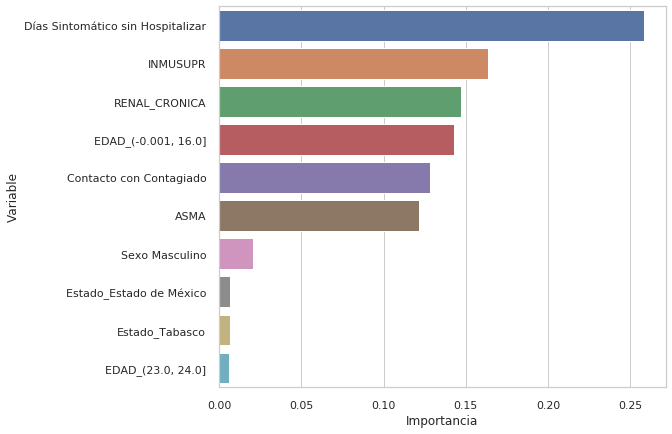

In [242]:
# fi = pd.DataFrame({'Variable': data.columns.values,
#                    'Importancia': clf.feature_importances_})
# fi = fi.sort_values(by='Importancia', ascending=False)

# sns.set(style="whitegrid")
# sns.barplot(x="Importancia", y="Variable", data=fi.head(10))